In [1]:
# Import libraries
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
import wave
%matplotlib inline

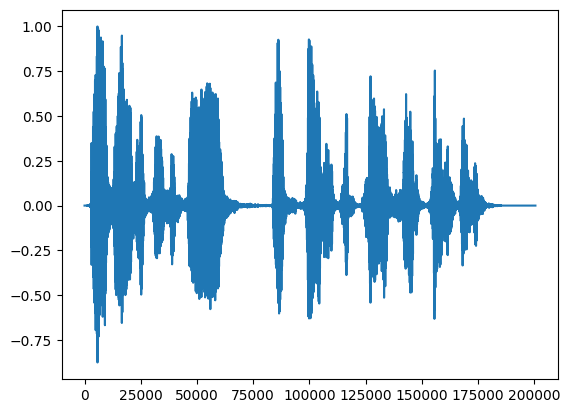

In [11]:
# Original audio
file_path = "/Users/chanhpham/PycharmProjects/Noise-Reduction/Audiofile.wav"
data, rate = librosa.load(file_path, sr=None)
plt.plot(data)

In [3]:
# Function to generate random noise by modifying frequency component (phases multiplication)
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

In [4]:
# Function to generate random noise within frequency range
def band_limited_noise(min_freq, max_freq, samples=1024, sample_rate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/sample_rate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

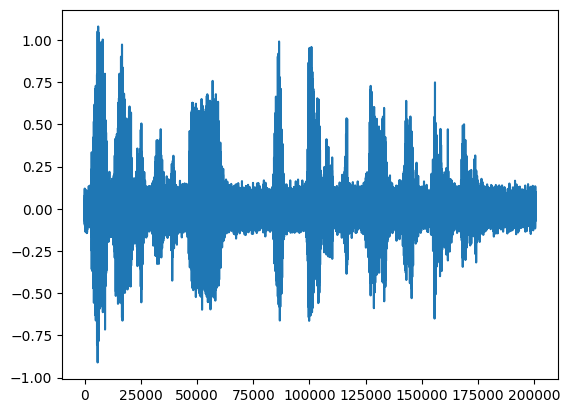

In [5]:
# Generate and add noise to the audio
noise_len = 2
noise_scale = 50
noise = band_limited_noise(min_freq= 100, max_freq= 4000, samples=len(data), sample_rate=rate) * noise_scale
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise
plt.plot(audio_clip_band_limited)

In [6]:
# Helper functions
import time
from datetime import timedelta as td

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
def _istft(y, hop_length, win_length):
    return librosa.istft(y,hop_length=hop_length, win_length=win_length)
def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x,ref=1.0,amin=1e-20,top_db=80.0)
def _db_to_amp(x):
    return librosa.core.amplitude_to_db(x,ref=1.0)

In [7]:
# Plotting the spectrogram with signal as the input
def plot_spectrogram(signal,title):
    fig, ax = plt.subplots(figsize=(20,4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1*np.max(np.abs(signal)),
        vmax=1*np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)

In [8]:
def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):

    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")


    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")

    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")



In [9]:
def removeNoise(   # to average the signal (voltage) of the positive-slope portion (rise) of a triangle wave to try to remove as much noise as possible.
    audio_clip,    # these clips are the parameters used on which we would do the respective operations
    noise_clip,
    n_grad_freq=2,    # how many frequency channels to smooth over with the mask.
    n_grad_time=4,    # how many time channels to smooth over with the mask.
    n_fft=2048,       # number audio of frames between STFT columns.
    win_length=2048,  # Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
    hop_length=512,   # number audio of frames between STFT columns.
    n_std_thresh=1.5, # how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
    prop_decrease=1.0, #To what extent should you decrease noise (1 = all, 0 = none)
    verbose=False,     # flag allows you to write regular expressions that look presentable
    visual=False,      #Whether to plot the steps of the algorithm
):
    if verbose:
        start = time.time()
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))

    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh

    if verbose:
        print("STFT on noise",td(seconds=time.time()-start))
        start = time.time()

    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))

    if verbose:
        print("STFT on signal",td(seconds=time.time()-start))
        start = time.time()

    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)

    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)

    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T

    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking",td(seconds=time.time()-start))
        start = time.time()

    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask Convolution",td(seconds=time.time()-start))
        start = time.time()

        # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask Application",td(seconds=time.time()-start))
        start = time.time()

        # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal Recovery",td(seconds=time.time()-start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask Applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked Signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered Spectrogram")
    return recovered_signal


STFT on noise 0:00:00.015137
STFT on signal 0:00:00.016430
[-32.97441482 -31.24618878 -25.35699633 ... -55.45829995 -55.45830776
 -55.45831006] -35.308101775626355
Masking 0:00:00.007465
Mask Convolution 0:00:00.022184
Mask Application 0:00:00.019609
Signal Recovery 0:00:00.059047


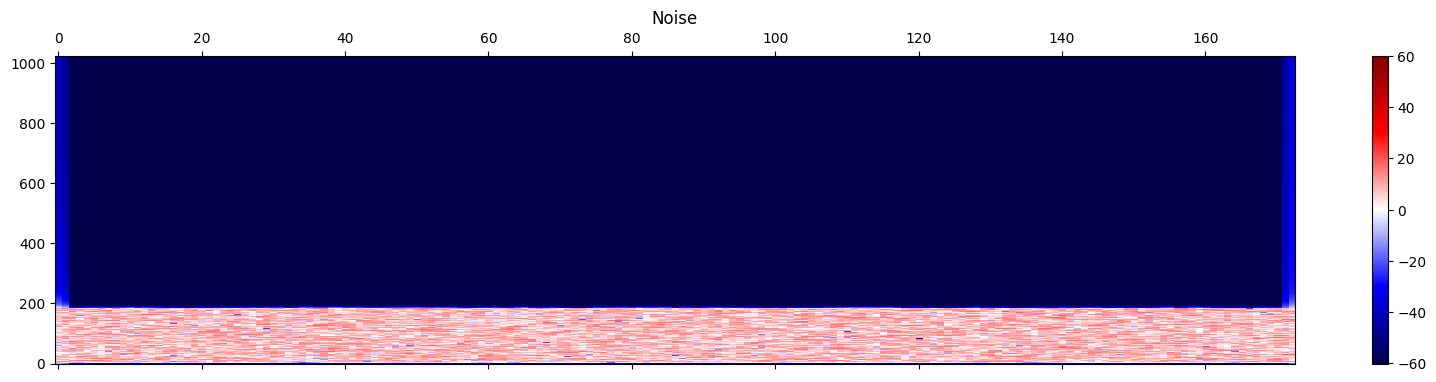

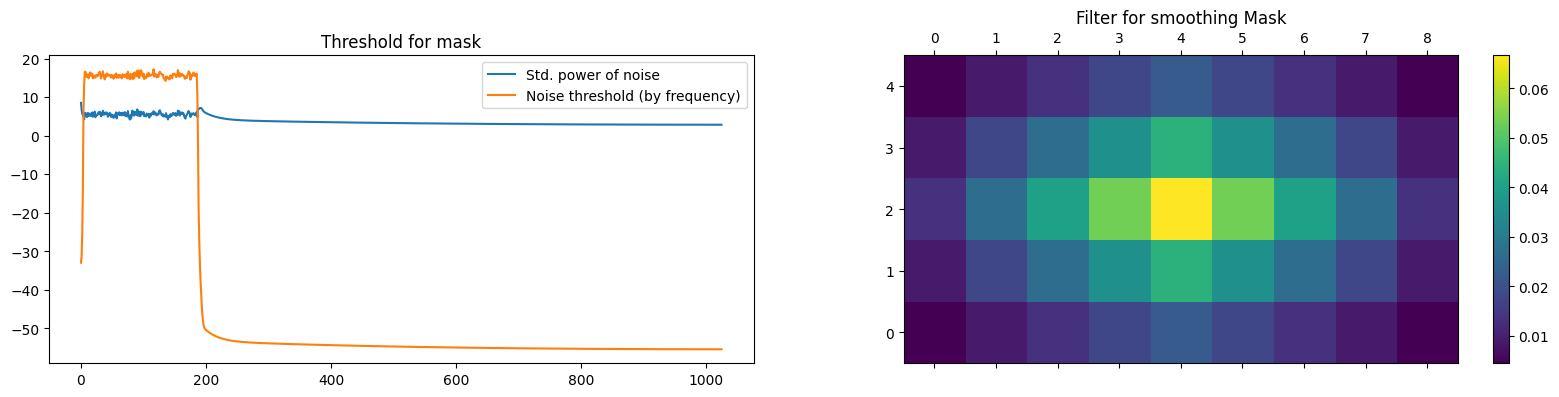

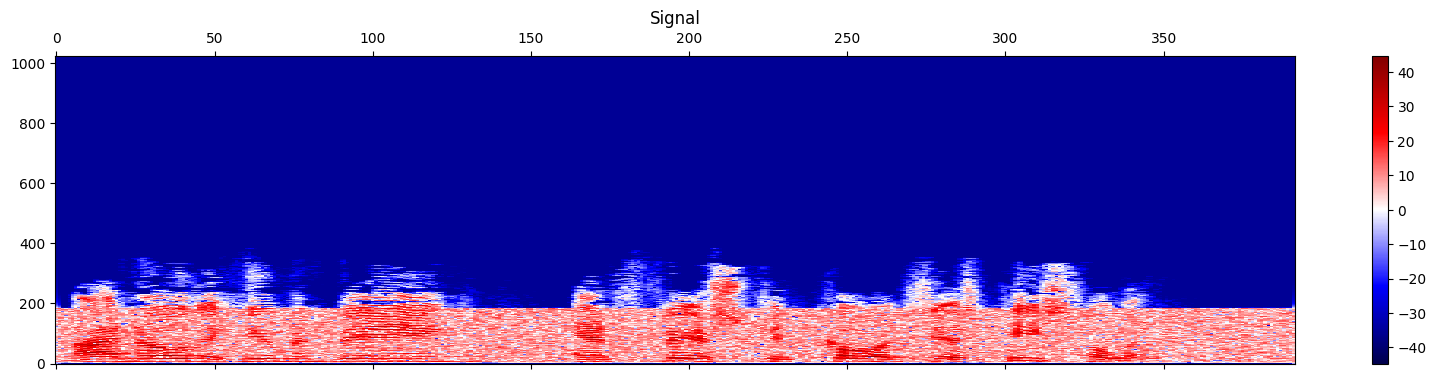

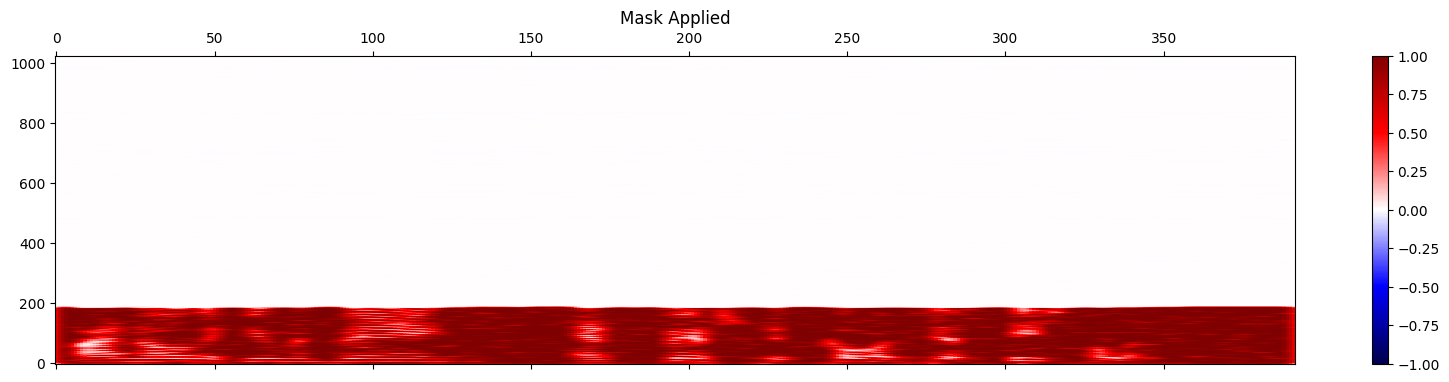

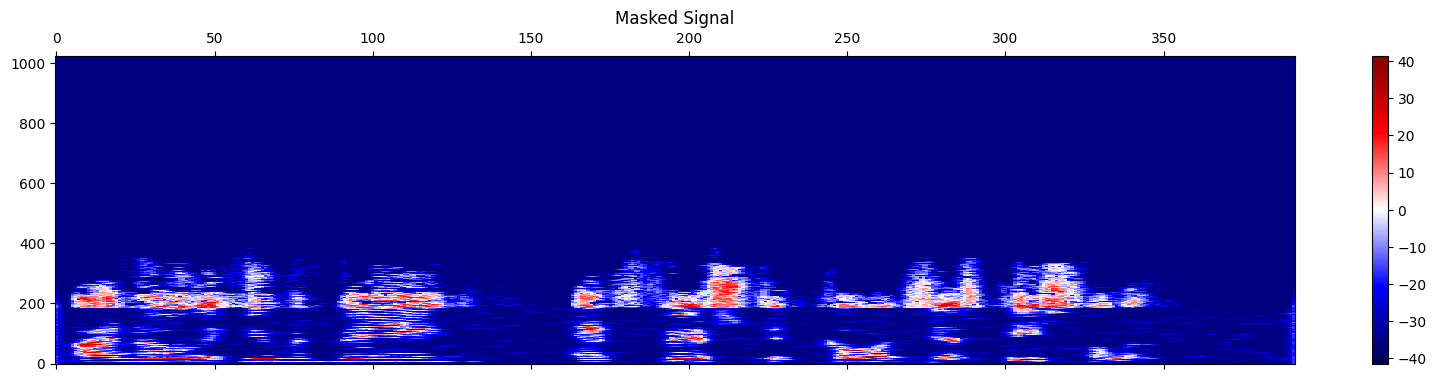

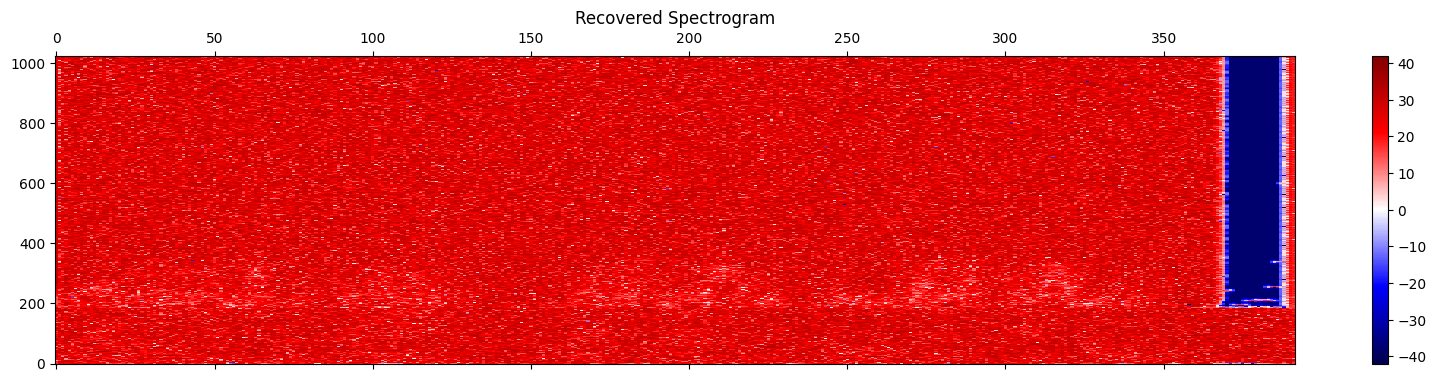

In [10]:
output = removeNoise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip,verbose=True, visual=True)

In [17]:
# Signal-to-Noise Ratio (SNR) Calculation
import numpy as np

min_length = min(len(output), len(audio_clip_band_limited))
output = output[:min_length]
audio_clip_band_limited = audio_clip_band_limited[:min_length]

signal_power_before = np.mean(data ** 2)
noise_power_before = np.mean((audio_clip_band_limited - data[:min_length]) ** 2)
snr_before = 10 * np.log10(signal_power_before / noise_power_before) if noise_power_before != 0 else float('inf')

print(f"Signal-to-Noise Ratio (SNR) before reduction: {snr_before:.2f} dB")

signal_power_after = np.mean(output ** 2)
noise_power_after = np.mean((output - audio_clip_band_limited) ** 2)
snr_after = 10 * np.log10(signal_power_after / noise_power_after) if noise_power_after != 0 else float('inf')

print(f"Signal-to-Noise Ratio (SNR) after reduction: {snr_after:.2f} dB")

Signal-to-Noise Ratio (SNR) before reduction: 7.14 dB
Signal-to-Noise Ratio (SNR) after reduction: 0.21 dB
